# Análise de Comportamento de Bots Suspeitos

In [1]:
# dependências
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community

import os
os.chdir("..")

from util.load_graph import load_graph_by_edge, get_driver, get_user_property_keys, get_user_properties, get_property_values, get_property_values_for_users

In [2]:
driver = get_driver()

In [3]:
suspected_bots = pd.read_csv('../data/all_suspected_bots.csv')
suspected_bots

,user_id
0,584b05446c0afec7298ccd5c0a11fa0a
1,e5fd2f4f70b2fbaca3c512672496eafe
2,6dea034b12e1631449450a0df69b752d
3,c923ed78ee5cf2ecbd55ab500f19a5d4
4,9f8f568a201ef009ea0ea2eba71a2d91
...,...
889,618249afda336c0c6943a985bad79c2b
890,75f92f053c96a3486fbed604529be2b5
891,03a05508f9a2899dcd3e689fb47ed900
892,83e8d4d4152aac9baa588ab6697be55d


In [4]:
high_conf_suspected_bots = pd.read_csv('../data/highest_confident_bots.csv')
high_conf_suspected_bots

,user_id
0,b1004f1254518ccb2e5ea5b8dd49b473
1,db60a046ca125348b9cd4dda729b99ec
2,826c407c3fc0646f32523e05bd57b459
3,036dd9c2c985d16f761e93ce7fe79919
4,8d1a3c5b2ba0f29df8a6a5be0bb66191
5,4d825174847c8e2d7db1c77a58e9b725
6,26cd985388f2cf5c0b7918ec6fb6a87f
7,9bc9ea4800037405bcdf572d68631bd3


## Comparação Scores Gerais vs Suspeitos

In [5]:
def compare_property_averages(driver, suspected_bots_df, user_id_col='user_id'):
    sample_user = suspected_bots_df[user_id_col].iloc[0]
    properties = get_user_properties(driver, sample_user)

    results = []

    for prop, val in properties.items():
        if not isinstance(val, (int, float)):
            continue

        all_vals = get_property_values(driver, prop)
        susp_vals = get_property_values_for_users(
            driver, prop, suspected_bots_df[user_id_col]
        )

        if len(all_vals) == 0 or len(susp_vals) == 0:
            continue

        results.append({
            "property": prop,
            "avg_all_users": np.mean(all_vals),
            "avg_suspected_bots": np.mean(susp_vals),
            "ratio_susp_vs_all": np.mean(susp_vals) / np.mean(all_vals)
        })

    df = pd.DataFrame(results).sort_values(
        by="ratio_susp_vs_all", ascending=False
    )

    return df

In [6]:
compare_property_averages(driver, suspected_bots)

,property,avg_all_users,avg_suspected_bots,ratio_susp_vs_all
7,viral_score,0.006145,0.066683,10.851909
3,misinfo_score,0.132189,0.670096,5.069229
5,shares_score,0.522397,1.928357,3.691365
6,synchronicity_score,9.805440,15.342482,1.564691
2,metronome_score,1.484604,1.504869,1.013650
0,content_originality,0.936023,0.776093,0.829138
4,network_diversity,0.557761,0.338266,0.606471
1,content_uniqueness,0.705840,0.292302,0.414120


In [7]:
compare_property_averages(driver, high_conf_suspected_bots)

,property,avg_all_users,avg_suspected_bots,ratio_susp_vs_all
3,misinfo_score,0.132189,1.537492,11.631015
5,shares_score,0.522397,2.771020,5.304435
2,metronome_score,1.484604,1.414798,0.952980
0,content_originality,0.936023,0.748413,0.799567
6,synchronicity_score,9.805440,6.314804,0.644010
4,network_diversity,0.557761,0.192369,0.344896
1,content_uniqueness,0.705840,0.083611,0.118456
7,viral_score,0.006145,0.000000,0.000000


# Encontrar subcomunidades

## Tipos de Similaridade e Arquétipos de Bots

### 1. SYNC_SIMILAR (Intensidade de Coordenação)

**O que mede:**  
Conecta bots que possuem um **Score de Sincronicidade** semelhante (relaciona quantos conteúdos compartilhados com quantos usuários).

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Núcleo Central*.  
  Um grupo coeso de bots responsável pela explosão inicial e rápida de mensagens.

- **Comunidade de baixo score:** *Periferia*.  
  Bots que ficam para trás ou participam apenas de ondas menores e específicas.

---

### 2. METRONOME_SIMILAR (Impressão Digital Temporal)

**O que mede:**  
Conecta bots que compartilham o mesmo **Coeficiente de Variação** nos intervalos de postagem.

**Arquétipos de bots identificados:**

- **Comunidade A:** *Relógios*.  
  Bots com variância próxima de zero (extremamente robóticos).

- **Comunidade B:** *Mímicos*.  
  Bots configurados com um algoritmo específico de aleatorização para parecerem humanos (por exemplo, variância maior, porém idêntica entre si).

---

### 3. SHARES_SIMILAR (Perfil de Volume)

**O que mede:**  
Conecta bots com volume total de mensagens semelhante.

**Arquétipos de bots identificados:**

- **Comunidade de alto volume:** *Canhões de Spam*.  
  Projetados para inundar grupos.

- **Comunidade de baixo volume:** *Atiradores de Elite*.  
  Bots que postam raramente.

---

### 4. MISINFO_SIMILAR (Carga Útil: Desinformação)

**O que mede:**  
Conecta bots que dedicam uma proporção semelhante de sua atividade a mensagens com alto score de desinformação.

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Especialistas em Desinformação*.  
  Contas criadas especificamente para espalhar narrativas direcionadas.

- **Comunidade de baixo score:** *Amplificadores Genéricos*.  
  Bots que amplificam conteúdo independentemente de sua veracidade.

---

### 5. VIRAL_SIMILAR (Carga Útil: Viralidade)

**O que mede:**  
Conecta bots com taxas de sucesso semelhantes na amplificação de conteúdo viral.

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Amplificadores*.  
  Bots projetados para fazer conteúdos existentes virarem tendência.

- **Comunidade de baixo score:**  
  Bots que introduzem conteúdo que não se tornou viral.

---

### 6. CONTENT_ORIGINALITY_SIMILAR (Lógica de Repetição)

**O que mede:**  
Conecta bots com proporções semelhantes de **Textos Únicos / Total de Mensagens**.

**Arquétipos de bots identificados:**

- **Comunidade ~0.1 (Baixa):** *Drones de Copiar e Colar*.  
  Bots que encaminham exatamente o mesmo texto centenas de vezes.

- **Comunidade ~0.9 (Alta):** *Bots Generativos*.  
  Bots que alteram levemente o texto a cada postagem.

---

### 7. CONTENT_UNIQUENESS_SIMILAR (Efeito Câmara de Eco)

**O que mede:**  
Conecta bots com base no quão “mainstream” é o conteúdo que compartilham globalmente.

**Arquétipos de bots identificados:**

- **Comunidade de baixa singularidade:** *Câmara de Eco*.  
  Bots que compartilham apenas o que milhares de outras pessoas já estão compartilhando (reforço de consenso).

- **Comunidade de alta singularidade:** *Injetores*.  
  Bots que introduzem narrativas raras ou novas na rede.

---

### 8. NETWORK_DIVERSITY_SIMILAR (Estratégia de Implantação)

**O que mede:**  
Conecta bots com proporções semelhantes de **Grupos Únicos / Total de Parceiros**.

**Arquétipos de bots identificados:**

- **Comunidade de baixa diversidade:** *Bots Enxame*.  
  Conjunto de bots que atacam o mesmo pequeno grupo de comunidades, sobrecarregando um alvo específico.

- **Comunidade de alta diversidade:** *Bots Ponte*.  
  Bots que atuam como conectores, levando conteúdo de uma comunidade para outros grupos.


In [8]:
from statistics import mean, median

def add_group_score_stats(
    G,
    group_attr,
    score_attr,
    prefix=None,
    round_digits=4
):
    if prefix is None:
        prefix = group_attr

    group_scores = {}

    for node, data in G.nodes(data=True):
        group = data.get(group_attr)
        score = data.get(score_attr)

        if group is None or score is None:
            continue

        group_scores.setdefault(group, []).append(score)

    group_stats = {}
    for g, scores in group_scores.items():
        if len(scores) == 0:
            continue
        group_stats[g] = {
            'mean': round(mean(scores), round_digits),
            'median': round(median(scores), round_digits)
        }

    for node, data in G.nodes(data=True):
        group = data.get(group_attr)
        if group in group_stats:
            data[f'{prefix}_mean_{score_attr}'] = group_stats[group]['mean']
            data[f'{prefix}_median_{score_attr}'] = group_stats[group]['median']


In [9]:
def classify_bot_behaviors(driver, suspected_bot_ids, output_dir='../data/visualization'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    similarity_graphs = {
        'SYNC_SIMILAR': ('synchronicity_score', 'Coordenação'),
        'METRONOME_SIMILAR': ('metronome_score', 'Variação temporal'),
        'SHARES_SIMILAR': ('shares_score', 'Compartilhamento'),
        'MISINFO_SIMILAR': ('misinfo_score', 'Desinformação'),
        'VIRAL_SIMILAR': ('viral_score', 'Viral'),
        'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade do conteúdo'),
        'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade do conteúdo'),
        'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade da rede')
    }
    
    bot_classifications = {}
    
    for graph_type, (score_name, behavior_name) in similarity_graphs.items():
        print(f"Processando {graph_type}...")
        G = load_graph_by_edge(driver, graph_type)
        
        suspected_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_bots = G.subgraph(suspected_nodes).copy()
        
        if len(G_bots.nodes()) < 2:
            print(f"Pulando {graph_type}: Menos que 2 nós")
            continue
        
        # CONNECTED COMPONENTS
        components = list(nx.connected_components(G_bots))
        print(f"Achou {len(components)} componentes conectados")

        for comp_id, comp in enumerate(components):
            subgraph = G_bots.subgraph(comp)
            density = nx.density(subgraph)
            avg_weight = (
                sum(d['weight'] for _, _, d in subgraph.edges(data=True)) /
                max(subgraph.number_of_edges(), 1)
            )

            for node in comp:
                G_bots.nodes[node]['component_id'] = comp_id
                G_bots.nodes[node]['component_size'] = len(comp)
                G_bots.nodes[node]['component_density'] = round(density, 4)
                G_bots.nodes[node]['component_avg_weight'] = round(avg_weight, 4)
                G_bots.nodes[node]['behavior_type'] = behavior_name

        # LOUVAIN
        louvain_communities = community.louvain_communities(
            G_bots, weight='weight', seed=42
        )
        print(f"Achou {len(louvain_communities)} comunidades Louvain")

        for i, comm in enumerate(louvain_communities):
            for node in comm:
                G_bots.nodes[node]['louvain_community'] = i
                G_bots.nodes[node]['louvain_community_size'] = len(comm)

                if node not in bot_classifications:
                    bot_classifications[node] = {}
                bot_classifications[node][behavior_name] = i

        # K-CORE
        try:
            core_numbers = nx.core_number(G_bots)
            for node, core in core_numbers.items():
                G_bots.nodes[node]['k_core'] = core
        except nx.NetworkXError:
            for node in G_bots.nodes():
                G_bots.nodes[node]['k_core'] = 0
        
        for node in G_bots.nodes():
            G_bots.nodes[node]['degree'] = G_bots.degree(node, weight='weight')

        add_group_score_stats(
            G_bots,
            group_attr='component_id',
            score_attr=score_name,
            prefix='component'
        )
        add_group_score_stats(
            G_bots,
            group_attr='louvain_community',
            score_attr=score_name,
            prefix='louvain'
        )
        
        gexf_filename = os.path.join(output_dir, f'{graph_type.lower()}_bot_communities.gexf')
        nx.write_gexf(G_bots, gexf_filename)
        print(f"  -> Salvou {gexf_filename}")
        print()
    
    if bot_classifications:
        df = pd.DataFrame.from_dict(bot_classifications, orient='index')
        df.index.name = 'user_id'
        df = df.reset_index()
        
        csv_filename = os.path.join(output_dir, 'bot_behavior_classifications.csv')
        df.to_csv(csv_filename, index=False)
        print(f"Salvo classificações {csv_filename}")
        
        return df
    else:
        return pd.DataFrame()

In [10]:
classify_bot_behaviors(driver, set(suspected_bots['user_id'].astype(str)))

Processando SYNC_SIMILAR...
Achou 18 componentes conectados
Achou 18 comunidades Louvain
  -> Salvou ../data/visualization/sync_similar_bot_communities.gexf

Processando METRONOME_SIMILAR...
Achou 7 componentes conectados
Achou 12 comunidades Louvain
  -> Salvou ../data/visualization/metronome_similar_bot_communities.gexf

Processando SHARES_SIMILAR...
Achou 8 componentes conectados
Achou 15 comunidades Louvain
  -> Salvou ../data/visualization/shares_similar_bot_communities.gexf

Processando MISINFO_SIMILAR...
Achou 8 componentes conectados
Achou 13 comunidades Louvain
  -> Salvou ../data/visualization/misinfo_similar_bot_communities.gexf

Processando VIRAL_SIMILAR...
Achou 2 componentes conectados
Achou 2 comunidades Louvain
  -> Salvou ../data/visualization/viral_similar_bot_communities.gexf

Processando CONTENT_ORIGINALITY_SIMILAR...
Achou 44 componentes conectados
Achou 44 comunidades Louvain
  -> Salvou ../data/visualization/content_originality_similar_bot_communities.gexf

Proce

,user_id,Coordenação,Variação temporal,Compartilhamento,Singularidade do conteúdo,Diversidade da rede,Desinformação,Originalidade do conteúdo,Viral
0,db60a046ca125348b9cd4dda729b99ec,0.0,3.0,0.0,1.0,10.0,NaN,NaN,NaN
1,e3afed0047b08059d0fada10f400c1e5,0.0,8.0,3.0,NaN,11.0,9.0,NaN,NaN
2,96c8dffb29c65cd1905239dc64196f03,0.0,4.0,7.0,44.0,2.0,0.0,0.0,NaN
3,8f7bd84a25f6cc58c013828e38ba339d,0.0,11.0,3.0,6.0,13.0,10.0,NaN,NaN
4,3185451bab1d45540590a83479fa78ed,0.0,8.0,3.0,71.0,10.0,11.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
889,a131a37e9efd8d70251cf3c661c9a273,NaN,NaN,11.0,NaN,10.0,NaN,NaN,NaN
890,2c3fff70a248262badad8f2828e9136b,NaN,NaN,13.0,16.0,4.0,NaN,NaN,NaN
891,17957a34a0bd0b49feb8b20d3f67fd92,NaN,NaN,13.0,27.0,1.0,NaN,NaN,NaN
892,e5fd2f4f70b2fbaca3c512672496eafe,NaN,NaN,13.0,NaN,2.0,NaN,NaN,NaN


In [11]:
#classify_bot_behaviors(driver, set(high_conf_suspected_bots['user_id'].astype(str)))

## Categorização em arquétipos

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

similarity_graphs = {
    'SYNC_SIMILAR': ('synchronicity', 'Coordenação', 'synchronicity_score'),
    'METRONOME_SIMILAR': ('metronome', 'Variação temporal', 'metronome_score'),
    'SHARES_SIMILAR': ('shares', 'Volume de Compartilhamento', 'shares_score'),
    'MISINFO_SIMILAR': ('misinfo', 'Desinformação', 'misinfo_score'),
    'VIRAL_SIMILAR': ('viral', 'Viralidade', 'viral_score'),
    'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade', 'content_uniqueness'),
    'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade de grupos', 'network_diversity'),
    'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade', 'content_originality')
}

def build_bot_archetypes(driver, suspected_bot_ids, similarity_graphs):
    print(f"--- Iniciando Mineração de {len(suspected_bot_ids)} suspeitos ---")
    
    user_features = {uid: {} for uid in suspected_bot_ids}
    
    for graph_type, (prefix, behavior_name, neo4j_prop) in similarity_graphs.items():
        print(f"Carregando grafo: {graph_type} ({behavior_name})...")
        
        G = load_graph_by_edge(driver, graph_type)
        
        relevant_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_sub = G.subgraph(relevant_nodes).copy()
        
        if len(G_sub) == 0:
            print(f"Nenhum bot suspeito encontrado na camada {graph_type}")
            for uid in suspected_bot_ids:
                user_features[uid][f'{prefix}_centrality'] = 0
                user_features[uid][f'{prefix}_density'] = 0
                user_features[uid][f'{prefix}_group_size'] = 0
                user_features[uid][f'{prefix}_score'] = 0
            continue

        # Calcula degree centrality
        centrality = nx.degree_centrality(G_sub)
        
        # Calcula densidade das componentes
        components = list(nx.connected_components(G_sub))
        node_density_map = {}
        node_size_map = {}
        for comp in components:
            comp_sub = G_sub.subgraph(comp)
            try:
                d = nx.density(comp_sub) 
            except:
                d = 0
            s = len(comp)
            for node in comp:
                node_density_map[node] = d
                node_size_map[node] = s
        
        # Mapeia features
        for uid in suspected_bot_ids:
            u_cent = 0
            u_dens = 0
            u_size = 0
            u_score = 0
            if uid in G_sub:
                u_cent = centrality.get(uid, 0)
                u_dens = node_density_map.get(uid, 0)
                u_size = node_size_map.get(uid, 0)
                
                u_score = G_sub.nodes[uid].get(neo4j_prop, 0)
                
            user_features[uid][f'{prefix}_centrality'] = u_cent
            user_features[uid][f'{prefix}_density'] = u_dens
            user_features[uid][f'{prefix}_group_size'] = u_size
            user_features[uid][f'{prefix}_score'] = u_score

    df = pd.DataFrame.from_dict(user_features, orient='index')
    return df.fillna(0)

In [13]:
def find_archetypes(df_features, n_clusters=4):
    print(f"Identificando {n_clusters} Arquétipos de Bots")
    
    # Normaliza dados
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), 
                             columns=df_features.columns, 
                             index=df_features.index)
    
    # Executa K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_scaled)
    
    df_features['Archetype_ID'] = clusters
    
    archetype_dna = df_features.groupby('Archetype_ID').mean()
    
    return df_features, archetype_dna

In [14]:
def visualize_archetypes(archetype_dna):
    plt.figure(figsize=(14, 8))
    
    scaler = MinMaxScaler()
    dna_scaled = pd.DataFrame(scaler.fit_transform(archetype_dna), 
                              columns=archetype_dna.columns, 
                              index=archetype_dna.index)
    
    sns.heatmap(dna_scaled.T, cmap='RdYlBu_r', annot=True, fmt=".2f", linewidths=.5)
    plt.title("DNA Comportamental dos Arquétipos de Bots", fontsize=16)
    plt.xlabel("ID do Arquétipo (Cluster)", fontsize=12)
    plt.ylabel("Características (Densidade/Centralidade)", fontsize=12)
    plt.tight_layout()
    plt.show()

--- Iniciando Mineração de 894 suspeitos ---
Carregando grafo: SYNC_SIMILAR (Coordenação)...
Carregando grafo: METRONOME_SIMILAR (Variação temporal)...
Carregando grafo: SHARES_SIMILAR (Volume de Compartilhamento)...
Carregando grafo: MISINFO_SIMILAR (Desinformação)...
Carregando grafo: VIRAL_SIMILAR (Viralidade)...
Carregando grafo: CONTENT_UNIQUENESS_SIMILAR (Singularidade)...
Carregando grafo: NETWORK_DIVERSITY_SIMILAR (Diversidade de grupos)...
Carregando grafo: CONTENT_ORIGINALITY_SIMILAR (Originalidade)...
Identificando 5 Arquétipos de Bots


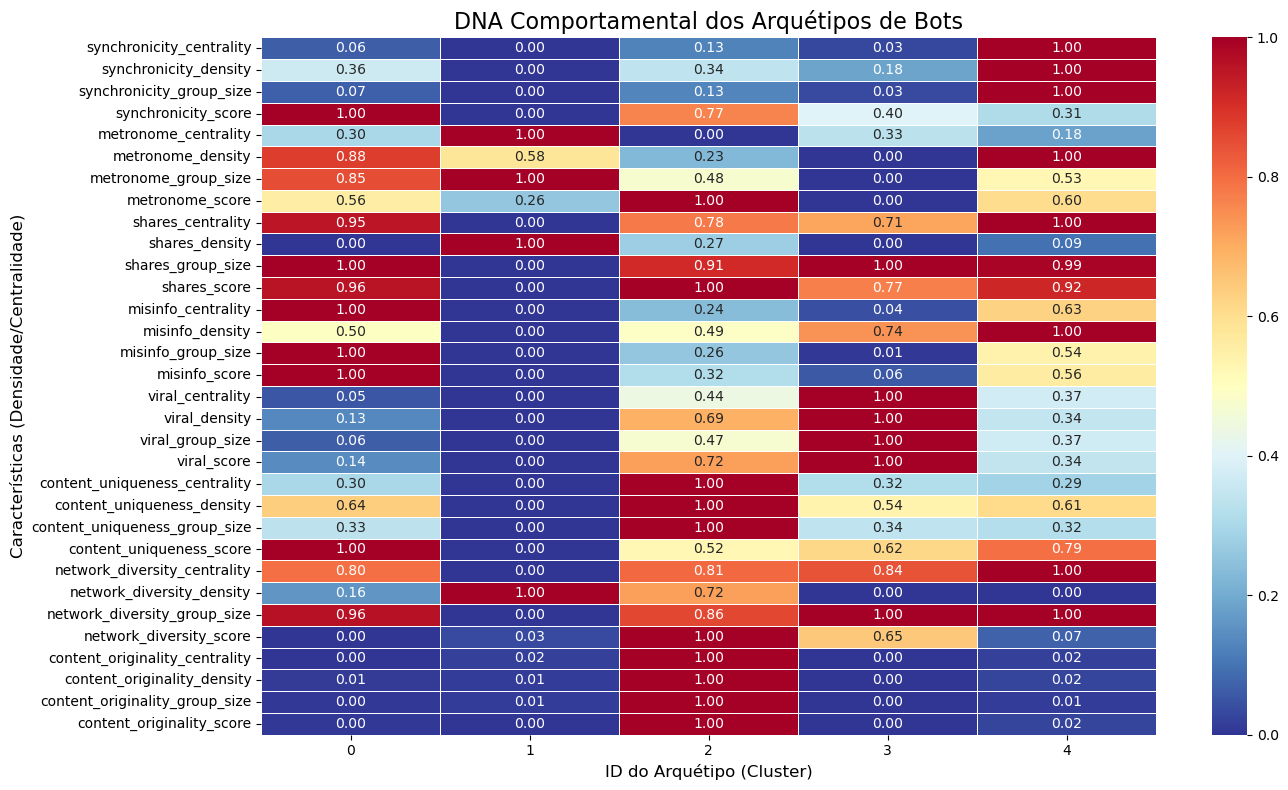

Análise concluída. Resultados salvos em 'bot_archetypes_final.csv'


In [15]:
suspected_bot_ids = set(suspected_bots['user_id'].astype(str))
df_bots = build_bot_archetypes(driver, suspected_bot_ids, similarity_graphs)

df_labeled, bot_dna = find_archetypes(df_bots, n_clusters=5)

visualize_archetypes(bot_dna)

df_labeled.to_csv("bot_archetypes_final.csv")
print("Análise concluída. Resultados salvos em 'bot_archetypes_final.csv'")

In [16]:
df_labeled

,synchronicity_centrality,synchronicity_density,synchronicity_group_size,synchronicity_score,metronome_centrality,metronome_density,metronome_group_size,metronome_score,shares_centrality,shares_density,...,content_uniqueness_score,network_diversity_centrality,network_diversity_density,network_diversity_group_size,network_diversity_score,content_originality_centrality,content_originality_density,content_originality_group_size,content_originality_score,Archetype_ID
3ea022a330d8b18002b2a303c7e29c4c,0.000000,0.0,0,0.000000,0.037780,0.147625,819,1.944585,0.114846,0.102504,...,0.000000,0.064426,0.050737,654,0.250000,0.0,0.0,0,0.0,3
3d379d83d01f36b93e39325e69f0bea5,0.000000,0.0,0,0.000000,0.201889,0.147625,819,1.272531,0.142857,0.102504,...,0.013216,0.051821,0.050737,654,0.186528,0.0,0.0,0,0.0,0
ffa912beb5fe4b992dc62766feace860,0.000000,0.0,0,0.000000,0.205431,0.147625,819,1.284489,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0,0.0,1
c9836d737ebe8fca6b18aeffd3726a36,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.124650,0.102504,...,0.020725,0.025210,0.050737,654,0.523810,0.0,0.0,0,0.0,3
2c8a9b9fd1f208a34b9b53d20b74073d,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.046218,0.102504,...,0.056338,0.022409,0.050737,654,0.514286,0.0,0.0,0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bb7a09e4926d64ab872aade2687e6fdd,0.000000,0.0,0,0.000000,0.268005,0.147625,819,1.409295,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0,0.0,1
f345b49c4a88f5eed142e8c107453aff,0.000000,0.0,0,0.000000,0.201889,0.147625,819,1.269939,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0,0.0,1
202b3b32ce10a3746eca9a1fbb9493a2,0.091912,1.0,26,1.386294,0.000000,0.000000,0,0.000000,0.134454,0.102504,...,0.012500,0.064426,0.050737,654,0.193182,0.0,0.0,0,0.0,3
408ac9ff4392f6d3935c8edf4d49fa0b,0.000000,0.0,0,0.000000,0.203070,0.147625,819,1.255044,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0,0.0,1


In [17]:
df_labeled.groupby('Archetype_ID').describe().to_csv('bot_archetypes_description.csv')